In [1]:
from pulp import *
from pulp import LpProblem, LpVariable, LpMinimize, LpInteger, lpSum, value, LpBinary,LpStatusOptimal
import pulp
import numpy as np
import pandas as pd
import time
from sklearn.preprocessing import MinMaxScaler
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings("ignore", message="Overwriting previously set objective.")
import utility
import docplex.mp.model
import docplex
import docplex_explainer
import mymetrics
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [2]:
# Load Dataset
dataset_name = 'Ionosphere' #Iris, Wine, Vertebral-Column, Pima, Parkinsons, Breast_Cancer, Blood_Transfusion, Ionosphere
#df_artificial = pd.read_csv('datasets/artificial/'+f'{dataset_name}_artificial.csv')
clf = joblib.load(f'models/{dataset_name}_svm_model.pkl')
loaded_bounds = np.load(f'models/{dataset_name}_data_bounds.npz')
lower_bound = loaded_bounds['lower_bound']
upper_bound = loaded_bounds['upper_bound']
np.random.seed(50)

In [8]:
d = 0.5
p = 0.25
X_test = pd.read_csv(f'{dataset_name}_results/{dataset_name}_X_test.csv')
onestep_coverages = []
twostep_coverages = []

In [9]:
for instance in X_test.values:
    #print(instance)
    artificial_lower_bounds = instance-d
    artificial_lower_bounds[artificial_lower_bounds<lower_bound] = lower_bound
    artificial_upper_bounds = instance+d
    artificial_upper_bounds[artificial_upper_bounds>upper_bound] = upper_bound
    #print(artificial_lower_bounds,artificial_upper_bounds)
    
    num_instances=100
    data = np.random.uniform(low=artificial_lower_bounds, high=artificial_upper_bounds, size=(num_instances, len(instance)))
    df_artificial = pd.DataFrame(data, columns=X_test.columns)
    df_artificial.loc[len(df_artificial)] = instance #Add original instance to the artificial set
    X_test_art = df_artificial.values
    test_dataset_df = df_artificial
    #print(clf.predict(instance.reshape(1, -1)))
    
    # Finding patterns classified as positive/negative
    positive_indexes,negative_indexes = utility.find_indexes(clf, instance.reshape(1, -1), threshold=0)
    #print(f"Positive patterns = {len(positive_indexes)},\nNegative patterns = {len(negative_indexes)}")
    
    #Variables for results
    #coverage_twostep = []
    pos_exp_twostep = []
    neg_exp_twostep = []
    
    #coverage_onestep = []
    pos_exp_onestep = []
    neg_exp_onestep = []
    #Generate Explanations for the patterns classified as negative
    for idx in  negative_indexes:  
        #Onestep
        exp = docplex_explainer.onestep(
                classifier = clf,
                dual_coef = clf.dual_coef_,
                support_vectors = clf.support_vectors_,
                intercept = clf.intercept_,
                lower_bound = lower_bound,
                upper_bound = upper_bound,
                data = (instance.reshape(1, -1)),
                positive = False)
        neg_exp_onestep.append(exp)
        #coverage_onestep.append(len(mymetrics.calculate_coverage(test_dataset_df, exp)))
        onestep_coverages.append(len(mymetrics.calculate_coverage(test_dataset_df, exp)))
    
    #Generate Explanations for the patterns classfied as positive
    for idx in positive_indexes:
        #Onestep
        exp = docplex_explainer.onestep(
                classifier = clf,
                dual_coef = clf.dual_coef_,
                support_vectors = clf.support_vectors_,
                intercept = clf.intercept_,
                lower_bound = lower_bound,
                upper_bound = upper_bound,
                data = (instance.reshape(1, -1)),
                positive = True)
        pos_exp_onestep.append(exp)
        #coverage_onestep.append(len(mymetrics.calculate_coverage(test_dataset_df, exp)))
        onestep_coverages.append(len(mymetrics.calculate_coverage(test_dataset_df, exp)))
    #Generate Explanations for the patterns classified as negative
    for idx in  negative_indexes:
        
        #Twostep
        exp_ = docplex_explainer.twostep(
                classifier = clf,
                dual_coef = clf.dual_coef_,
                support_vectors = clf.support_vectors_,
                intercept = clf.intercept_,
                lower_bound = lower_bound,
                upper_bound = upper_bound,
                data = (instance.reshape(1, -1)),
                p = p,
                positive = False)
        neg_exp_twostep.append(exp_)
        #coverage_twostep.append(len(mymetrics.calculate_coverage(test_dataset_df, exp_)))
        twostep_coverages.append(len(mymetrics.calculate_coverage(test_dataset_df, exp_)))
    
    #Generate Explanations for the patterns classfied as positive
    for idx in positive_indexes:
        #Twostep
        exp_ = docplex_explainer.twostep(
                classifier = clf,
                dual_coef = clf.dual_coef_,
                support_vectors = clf.support_vectors_,
                intercept = clf.intercept_,
                lower_bound = lower_bound,
                upper_bound = upper_bound,
                data = (instance.reshape(1, -1)),
                p = p,
                positive = True)
        pos_exp_twostep.append(exp_)
        #coverage_twostep.append(len(mymetrics.calculate_coverage(test_dataset_df, exp_)))
        twostep_coverages.append(len(mymetrics.calculate_coverage(test_dataset_df, exp_)))
        
    
# Compute means and standard deviations
def compute_mean_std(arr):
    return np.mean(arr), np.std(arr)

# Compute relative percentage differences
def relative_percentage_diff(new, old):
    if np.any(old == 0):
        print(f'Warning: found possible division by zero')
        return np.where(old != 0, ((new - old) / old) * 100, np.nan)
    return ((new - old) / old) * 100

# Ensure all lists are NumPy arrays
onestep_coverages = np.array(onestep_coverages)
twostep_coverages = np.array(twostep_coverages)


(coverage_mean_onestep, coverage_std_onestep) = compute_mean_std(onestep_coverages)
(coverage_mean_twostep, coverage_std_twostep) = compute_mean_std(twostep_coverages)


coverage_mean_diff = relative_percentage_diff(coverage_mean_twostep, coverage_mean_onestep)
coverage_std_diff = relative_percentage_diff(coverage_std_twostep, coverage_std_onestep)
coverage_relative_pointwise = relative_percentage_diff(twostep_coverages, onestep_coverages)
coverage_relative_mean = np.mean(coverage_relative_pointwise)
coverage_relative_std = np.std(coverage_relative_pointwise)
    
# Organize Data
all_metrics_data = {
    'Metric': ['Coverage'],
    'ONESTEP_MEAN': [coverage_mean_onestep],
    'ONESTEP_STD': [coverage_std_onestep],
    'TWOSTEP_MEAN': [coverage_mean_twostep],
    'TWOSTEP_STD': [coverage_std_twostep],
    'MEAN_DIFF_%': [coverage_mean_diff],
    'STD_DIFF_%': [coverage_std_diff],
    'POINTWISE_MEAN_%': [coverage_relative_mean],
    'POINTWISE_STD_%': [coverage_relative_std]
}
# Display and save
all_metrics_df = pd.DataFrame(all_metrics_data)
display(all_metrics_df)
#all_metrics_df.to_csv(f'{dataset_name}_results/results_artificial_{p}.csv', index=False)

#Save Raw Metric Data
raw_df = pd.DataFrame({
    "coverage_onestep": onestep_coverages, 
    "coverage_twostep": twostep_coverages,
    "coverage_relative_%": coverage_relative_pointwise
})

display(raw_df)
    

C:\Users\Mateus\AppData\Local\Temp\ipykernel_13560\1511138334.py:104: RuntimeWarning: invalid value encountered in scalar divide
  return np.where(old != 0, ((new - old) / old) * 100, np.nan)


,Metric,ONESTEP_MEAN,ONESTEP_STD,TWOSTEP_MEAN,TWOSTEP_STD,MEAN_DIFF_%,STD_DIFF_%,POINTWISE_MEAN_%,POINTWISE_STD_%
0,Coverage,1.0,0.0,1.0,0.0,0.0,nan,0.0,0.0


,coverage_onestep,coverage_twostep,coverage_relative_%
0,1,1,0.0
1,1,1,0.0
2,1,1,0.0
3,1,1,0.0
4,1,1,0.0
...,...,...,...
259,1,1,0.0
260,1,1,0.0
261,1,1,0.0
262,1,1,0.0


In [10]:
raw_df.min(), raw_df.max()

(coverage_onestep       1.0
 coverage_twostep       1.0
 coverage_relative_%    0.0
 dtype: float64,
 coverage_onestep       1.0
 coverage_twostep       1.0
 coverage_relative_%    0.0
 dtype: float64)

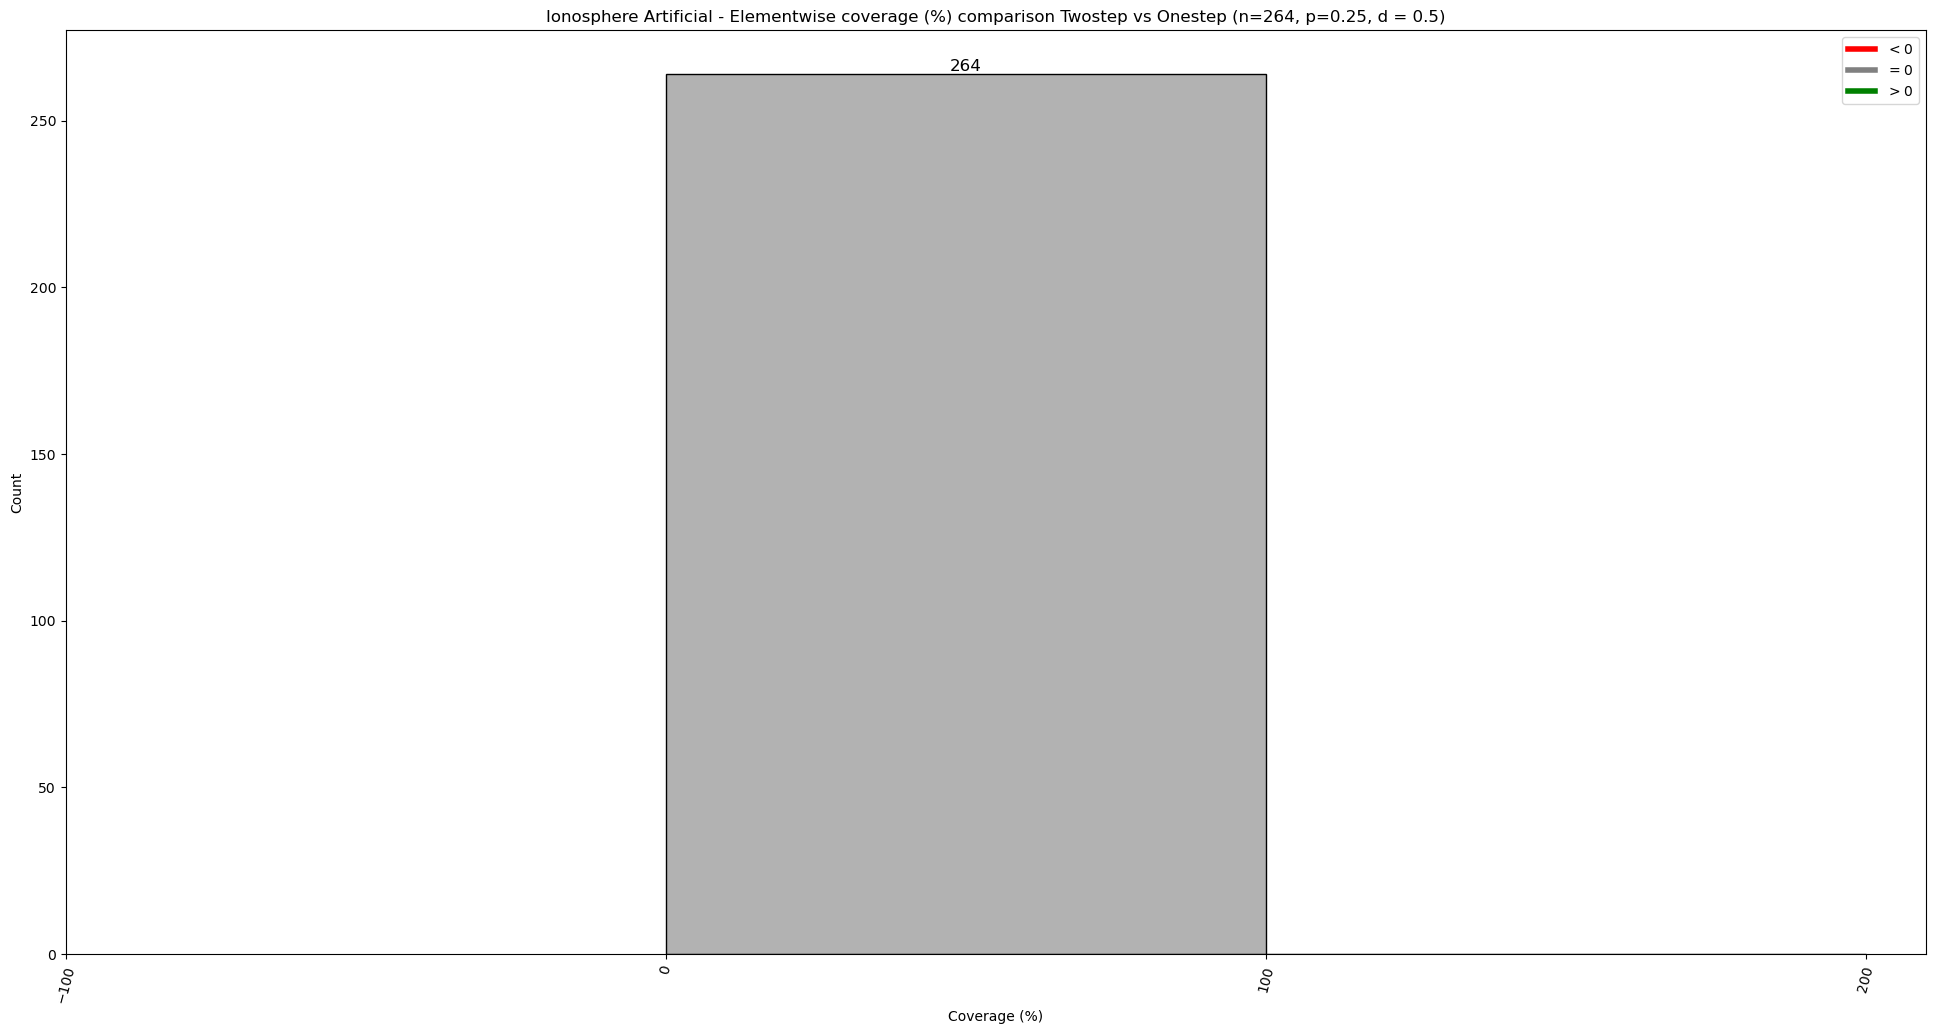

In [11]:
# Compute relative proportion
relative_proportion = np.where(
    raw_df['coverage_onestep'] != 0,
    ((raw_df['coverage_twostep'] - raw_df['coverage_onestep']) / raw_df['coverage_onestep']) * 100,
    np.nan
)

# Separate values
values_lt_0 = relative_proportion[relative_proportion < 0]
values_eq_0 = relative_proportion[relative_proportion == 0]
values_gt_0 = relative_proportion[relative_proportion > 0]

# Define bin width and edges
bin_width = 100
min_value = -bin_width if np.nanmin(relative_proportion) >= -bin_width else np.ceil(np.nanmin(relative_proportion) / -bin_width) * -bin_width
max_value = np.nanmax(relative_proportion) + bin_width

bin_edges_lt_0 = np.arange(min_value, bin_width+1, bin_width)  # Bins for < 0 values
bin_edges_gt_0 = np.arange(0, max_value+1+bin_width, bin_width)  # Bins for > 0 values

# Create figure
plt.figure(figsize=(24, 12))

# Plot histograms separately
ax_list = []
if len(values_lt_0) > 0:
    ax_lt_0 = sns.histplot(values_lt_0, bins=bin_edges_lt_0, kde=False, color='red', alpha=0.6, label=r'$ < 0$')
    ax_list.append(ax_lt_0)
if len(values_eq_0) > len(values_gt_0[values_gt_0<bin_width]):    
    ax_eq_0 = sns.histplot(values_eq_0, bins=bin_edges_gt_0, kde=False, color='gray', alpha=0.6, label=r'$ = 0$')
    ax_list.append(ax_eq_0)
else:
    ax_eq_0 = sns.histplot(values_eq_0, bins=bin_edges_gt_0, kde=False, color='gray', alpha=1, label=r'$ = 0$')
    ax_list.append(ax_eq_0)

if len(values_gt_0) > 0:
    ax_gt_0 = sns.histplot(values_gt_0, bins=bin_edges_gt_0, kde=False, color='green', alpha=0.6, label=r'$ > 0$')
    ax_list.append(ax_gt_0)

# Add numbers above each bin
for ax in ax_list:
    for patch in ax.patches:
        height = patch.get_height()
        if height > 0:
            plt.text(
                patch.get_x() + patch.get_width() / 2,  # Centered in bin
                height,  # Position above the bar
                f'{int(height)}',  # Rounded count
                ha='center', va='bottom', fontsize=12
            )

# Adjust xticks
xticks = np.arange(min_value, max_value+1+bin_width, bin_width)
plt.xticks(xticks, rotation=75)

# Labels and title
plt.ylabel('Count')
plt.xlabel('Coverage (%)')
plt.title(f'{dataset_name} Artificial - Elementwise coverage (%) comparison Twostep vs Onestep (n={len(X_test)}, p={p}, d = {d})')

# Correct legend
plt.legend(
    labels=[r'$ < 0$', r'$ = 0$', r'$ > 0$'],  
    handles=[
        plt.Line2D([0], [0], color='red', lw=4),
        plt.Line2D([0], [0], color='gray', lw=4),
        plt.Line2D([0], [0], color='green', lw=4)
    ]
)

#plt.savefig(f"{dataset_name}_results/{dataset_name}_artificial_coverage_{p}.eps", format='eps', dpi=300, bbox_inches='tight')
plt.savefig(f"relative_coverage/{dataset_name}_artificial_coverage_{p}.jpg", format='jpg', dpi=300, bbox_inches='tight')
plt.show()


In [12]:
xticks

array([-100.,    0.,  100.,  200.])